<a href="https://colab.research.google.com/github/LineIntegralx/CalligraNet/blob/main/EDA%20%26%20Preprocessing/Synthetic_%26_Augmented_HICMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install -q scikit-learn

import os
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.rcParams["figure.dpi"] = 120


In [3]:
# RAW generated data
GEN_RAW_DIR   = Path("/content/drive/MyDrive/EECE693_Project/Generated_Data")
GEN_IMAGES    = GEN_RAW_DIR / "images"
GEN_LABELS_CSV = GEN_RAW_DIR / "labels.csv"

# OUTPUT base for preprocessed & split data
OUT_BASE = Path("/content/drive/MyDrive/EECE693_Project/Preprocessed_Generated")

OUT_TRAIN_IMG = OUT_BASE / "train" / "images"
OUT_VAL_IMG   = OUT_BASE / "val" / "images"
OUT_TEST_IMG  = OUT_BASE / "test" / "images"

for p in [OUT_TRAIN_IMG, OUT_VAL_IMG, OUT_TEST_IMG]:
    p.mkdir(parents=True, exist_ok=True)

OUT_TRAIN_CSV = OUT_BASE / "train_labels.csv"
OUT_VAL_CSV   = OUT_BASE / "val_labels.csv"
OUT_TEST_CSV  = OUT_BASE / "test_labels.csv"

OUT_BASE


PosixPath('/content/drive/MyDrive/EECE693_Project/Preprocessed_Generated')

In [4]:
# --- Consistency check between GEN_IMAGES and GEN_LABELS_CSV ---

# 1) Load labels and guess which column holds the image filename
labels_df = pd.read_csv(GEN_LABELS_CSV)

possible_name_cols = ["filename", "image", "image_name", "img", "img_name", "file", "file_name"]
fname_col = None
for c in labels_df.columns:
    if c.lower() in possible_name_cols:
        fname_col = c
        break
if fname_col is None:
    # fallback: assume first column is the filename
    fname_col = labels_df.columns[0]

# normalize to plain filenames (no paths)
labels_df[fname_col] = labels_df[fname_col].astype(str)
label_names = labels_df[fname_col].apply(lambda x: Path(x).name)

# 2) Collect all image files in the folder
valid_exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
image_files = [p for p in GEN_IMAGES.iterdir() if p.suffix.lower() in valid_exts]
image_names = set(p.name for p in image_files)

label_name_set = set(label_names)

# 3) Find inconsistencies
# a) Rows in CSV whose image file does NOT exist
missing_in_folder = label_name_set - image_names

# b) Image files in folder that are NOT referenced in CSV
unlabeled_images = image_names - label_name_set

# 4) Delete bad CSV rows (no corresponding image)
rows_to_drop = labels_df[label_names.isin(missing_in_folder)].index
num_rows_dropped = len(rows_to_drop)
labels_df_clean = labels_df.drop(rows_to_drop).reset_index(drop=True)

# 5) Delete image files that are not in CSV
num_imgs_deleted = 0
for p in image_files:
    if p.name in unlabeled_images:
        p.unlink()
        num_imgs_deleted += 1

# 6) Remove duplicate filename rows in CSV (keep first)
dup_mask = labels_df_clean.duplicated(subset=[fname_col], keep="first")
num_dups_removed = int(dup_mask.sum())
labels_df_clean = labels_df_clean[~dup_mask].reset_index(drop=True)

# 7) Overwrite cleaned CSV
labels_df_clean.to_csv(GEN_LABELS_CSV, index=False)

print("=== Consistency check report ===")
print(f"Filename column used           : {fname_col}")
print(f"Rows removed (no image file)   : {num_rows_dropped}")
print(f"Images deleted (no CSV label)  : {num_imgs_deleted}")
print(f"Duplicate label rows removed   : {num_dups_removed}")
print(f"Final number of labels         : {len(labels_df_clean)}")
print(f"Final number of image files    : {len(list(GEN_IMAGES.iterdir()))}")


=== Consistency check report ===
Filename column used           : img_name
Rows removed (no image file)   : 581
Images deleted (no CSV label)  : 0
Duplicate label rows removed   : 188
Final number of labels         : 9145
Final number of image files    : 9145


In [5]:
TARGET_HEIGHT = 256      # same as before
MIN_H = 50               # drop very small images
MIN_W = 100
PAD_DIVISOR = 32         # pad width to multiple of 32

# CLAHE
clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))

def preprocess_image(src_path: Path,
                     dst_path: Path,
                     target_height: int = TARGET_HEIGHT,
                     min_h: int = MIN_H,
                     min_w: int = MIN_W,
                     pad_divisor: int = PAD_DIVISOR):
    """
    HICMA-style preprocessing:
      1) grayscale
      2) drop tiny images
      3) CLAHE
      4) resize to fixed height, keep aspect ratio
      5) letterbox to white canvas, width multiple of pad_divisor

    Returns (new_h, new_w) or None if skipped.
    """
    img = cv2.imread(str(src_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    h, w = img.shape[:2]

    # drop tiny
    if h < min_h or w < min_w:
        return None

    # CLAHE
    img = clahe.apply(img)

    # resize to fixed height
    scale = target_height / float(h)
    new_w = int(round(w * scale))
    img_resized = cv2.resize(
        img, (new_w, target_height), interpolation=cv2.INTER_AREA
    )

    # letterbox to multiple-of-32 width
    if pad_divisor is not None:
        padded_w = int(np.ceil(new_w / pad_divisor) * pad_divisor)
    else:
        padded_w = new_w

    canvas = np.full((target_height, padded_w), 255, dtype=np.uint8)
    x0 = (padded_w - new_w) // 2
    canvas[:, x0:x0+new_w] = img_resized

    cv2.imwrite(str(dst_path), canvas)

    return target_height, padded_w


In [6]:
df_raw = pd.read_csv(GEN_LABELS_CSV)

# Drop unnamed index column if exists
first_col = df_raw.columns[0]
if first_col.lower().startswith("unnamed"):
    df_raw = df_raw.drop(columns=[first_col])

df_raw["img_name"] = df_raw["img_name"].astype(str).str.strip()

print("Total generated rows:", len(df_raw))
print(df_raw["class"].value_counts())
df_raw.head()


Total generated rows: 9145
class
Kufic      3654
Diwani     2870
Thuluth    2621
Name: count, dtype: int64


,img_name,class,label
0,Diwani_1_sample1208.png,Diwani,الفشل هو مجرد تجربة، والتعلم منه هو الطريق إلى...
1,Diwani_1_sample4484.png,Diwani,هل تفضل الذهاب إلى الأماكن الجديدة أم زيارة ال...
2,Diwani_1_sample22841.png,Diwani,أنا أحب القراءة عن الفلسفة، بينما يفضل هو قراء...
3,Diwani_1_sample2249.png,Diwani,الفرص لا تأتي كل يوم، فاغتنمها.
4,Diwani_1_sample9208.png,Diwani,من الجيد أن تحافظ على عقلية إيجابية حتى في الأ...


In [7]:
# 80 / 10 / 10 stratified by style
train_df, temp_df = train_test_split(
    df_raw,
    test_size=0.2,
    stratify=df_raw["class"],
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["class"],
    random_state=42,
)

len(train_df), len(val_df), len(test_df)


(7316, 914, 915)

In [8]:
print("Train class counts:\n", train_df["class"].value_counts(), "\n")
print("Val class counts:\n",   val_df["class"].value_counts(), "\n")
print("Test class counts:\n",  test_df["class"].value_counts())


Train class counts:
 class
Kufic      2923
Diwani     2296
Thuluth    2097
Name: count, dtype: int64 

Val class counts:
 class
Kufic      365
Diwani     287
Thuluth    262
Name: count, dtype: int64 

Test class counts:
 class
Kufic      366
Diwani     287
Thuluth    262
Name: count, dtype: int64


In [9]:
def preprocess_split(df_split: pd.DataFrame,
                     src_images_dir: Path,
                     dst_images_dir: Path):
    processed_rows = []
    skipped_missing = []
    skipped_tiny = []

    for _, row in tqdm(df_split.iterrows(), total=len(df_split),
                       desc=f"Preprocessing → {dst_images_dir.parent.name}"):
        img_name = row["img_name"]
        src = src_images_dir / img_name

        if not src.exists():
            skipped_missing.append(img_name)
            continue

        stem = src.stem
        dst_name = stem + ".png"      # save preprocessed as PNG
        dst = dst_images_dir / dst_name

        res = preprocess_image(src, dst)
        if res is None:
            skipped_tiny.append(img_name)
            continue

        new_h, new_w = res

        new_row = row.copy()
        new_row["img_name"] = dst_name
        new_row["height"] = new_h
        new_row["width"] = new_w
        processed_rows.append(new_row)

    df_out = pd.DataFrame(processed_rows)

    stats = {
        "total_rows": len(df_split),
        "processed": len(df_out),
        "skipped_missing": len(skipped_missing),
        "skipped_tiny": len(skipped_tiny),
    }
    return df_out, stats


In [10]:
df_train_proc, stats_train = preprocess_split(train_df, GEN_IMAGES, OUT_TRAIN_IMG)
df_val_proc,   stats_val   = preprocess_split(val_df,   GEN_IMAGES, OUT_VAL_IMG)
df_test_proc,  stats_test  = preprocess_split(test_df,  GEN_IMAGES, OUT_TEST_IMG)

print("Train stats:", stats_train)
print("Val stats  :", stats_val)
print("Test stats :", stats_test)


Preprocessing → test: 100%|██████████| 915/915 [05:53<00:00,  2.58it/s]

Train stats: {'total_rows': 7316, 'processed': 7316, 'skipped_missing': 0, 'skipped_tiny': 0}
Val stats  : {'total_rows': 914, 'processed': 914, 'skipped_missing': 0, 'skipped_tiny': 0}
Test stats : {'total_rows': 915, 'processed': 915, 'skipped_missing': 0, 'skipped_tiny': 0}


In [11]:
df_train_proc.to_csv(OUT_TRAIN_CSV, index=False)
df_val_proc.to_csv(OUT_VAL_CSV, index=False)
df_test_proc.to_csv(OUT_TEST_CSV, index=False)

OUT_TRAIN_CSV, OUT_VAL_CSV, OUT_TEST_CSV


(PosixPath('/content/drive/MyDrive/EECE693_Project/Preprocessed_Generated/train_labels.csv'),
 PosixPath('/content/drive/MyDrive/EECE693_Project/Preprocessed_Generated/val_labels.csv'),
 PosixPath('/content/drive/MyDrive/EECE693_Project/Preprocessed_Generated/test_labels.csv'))

In [12]:
print("Preprocessed train:", len(df_train_proc))
print("Preprocessed val  :", len(df_val_proc))
print("Preprocessed test :", len(df_test_proc))

print("\nTrain classes:\n", df_train_proc["class"].value_counts())
print("\nVal classes:\n", df_val_proc["class"].value_counts())
print("\nTest classes:\n", df_test_proc["class"].value_counts())


Preprocessed train: 7316
Preprocessed val  : 914
Preprocessed test : 915

Train classes:
 class
Kufic      2923
Diwani     2296
Thuluth    2097
Name: count, dtype: int64

Val classes:
 class
Kufic      365
Diwani     287
Thuluth    262
Name: count, dtype: int64

Test classes:
 class
Kufic      366
Diwani     287
Thuluth    262
Name: count, dtype: int64


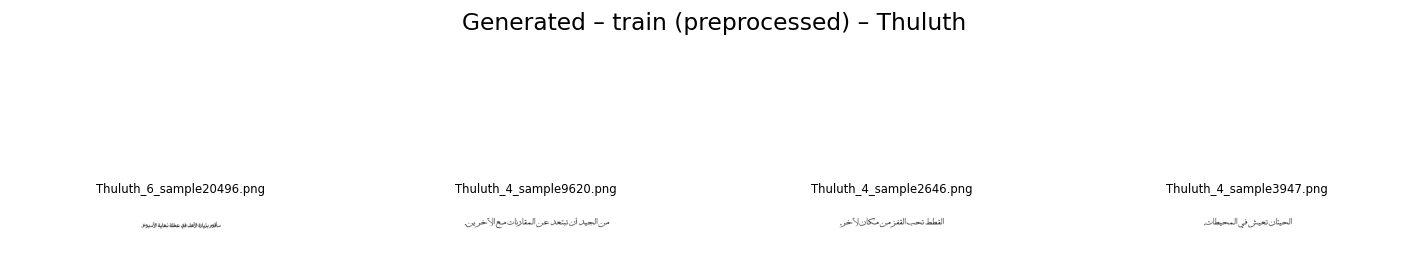

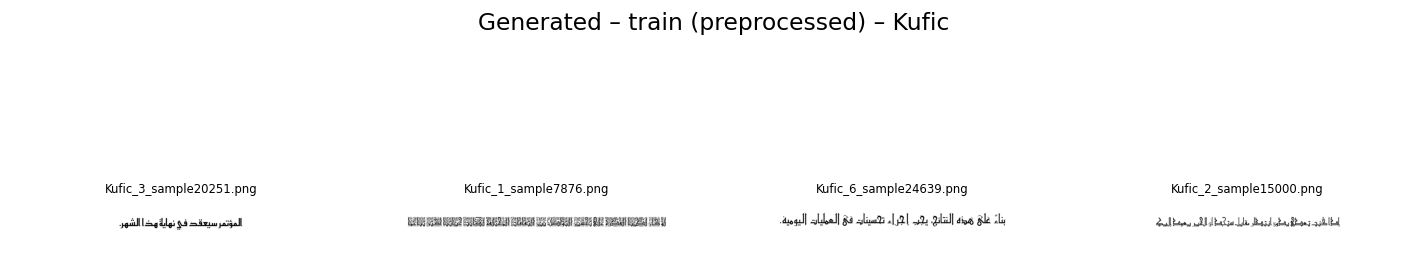

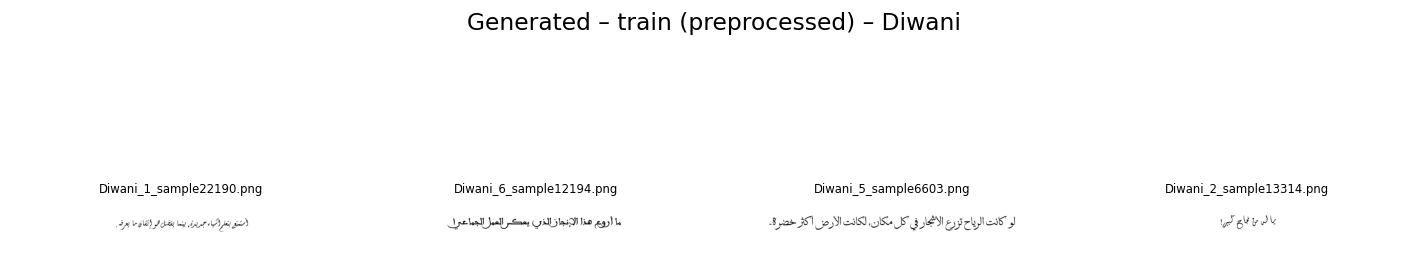

In [15]:
def show_samples(df, img_dir, title_prefix, n_per_style=4):
    styles = df["class"].unique()
    for style in styles:
        sub = df[df["class"] == style]
        if len(sub) == 0:
            continue
        sample = sub.sample(min(n_per_style, len(sub)), random_state=42)

        plt.figure(figsize=(3 * len(sample), 3))
        plt.suptitle(f"{title_prefix} – {style}", fontsize=14)
        for i, (_, row) in enumerate(sample.iterrows(), start=1):
            img_path = img_dir / row["img_name"]
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            plt.subplot(1, len(sample), i)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(row["img_name"], fontsize=7)
        plt.tight_layout(rect=[0, 0, 1, 0.9])
        plt.show()

show_samples(df_train_proc, OUT_TRAIN_IMG, "Generated – train (preprocessed)", n_per_style=4)


In [14]:
from pathlib import Path

def check_split_consistency(split_name, img_dir, labels_csv):
    print(f"\n=== Checking {split_name} split ===")
    df = pd.read_csv(labels_csv)
    df["img_name"] = df["img_name"].astype(str).str.strip()

    # set of filenames from CSV
    csv_names = set(df["img_name"].tolist())

    # set of filenames actually in the folder (only images)
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
    fs_names = set(
        f.name for f in Path(img_dir).iterdir()
        if f.is_file() and f.suffix.lower() in exts
    )

    missing_in_fs  = csv_names - fs_names   # label but no image
    extra_in_fs    = fs_names - csv_names   # image but no label

    print(f"Total labels in CSV : {len(csv_names)}")
    print(f"Total images in dir : {len(fs_names)}")
    print(f"Labels without image: {len(missing_in_fs)}")
    print(f"Images without label: {len(extra_in_fs)}")

    if missing_in_fs:
        print("\nExamples of labels with no image:")
        print(list(missing_in_fs)[:10])

    if extra_in_fs:
        print("\nExamples of images with no label:")
        print(list(extra_in_fs)[:10])

    # Optional: raise error if mismatch
    if not missing_in_fs and not extra_in_fs:
        print("✅ Split is consistent: 1–1 mapping between images and labels.")
    else:
        print("⚠️ Inconsistencies found in this split.")


check_split_consistency("train", OUT_TRAIN_IMG, OUT_TRAIN_CSV)
check_split_consistency("val",   OUT_VAL_IMG,   OUT_VAL_CSV)
check_split_consistency("test",  OUT_TEST_IMG,  OUT_TEST_CSV)



=== Checking train split ===
Total labels in CSV : 7316
Total images in dir : 7316
Labels without image: 0
Images without label: 0
✅ Split is consistent: 1–1 mapping between images and labels.

=== Checking val split ===
Total labels in CSV : 914
Total images in dir : 914
Labels without image: 0
Images without label: 0
✅ Split is consistent: 1–1 mapping between images and labels.

=== Checking test split ===
Total labels in CSV : 915
Total images in dir : 915
Labels without image: 0
Images without label: 0
✅ Split is consistent: 1–1 mapping between images and labels.


#**---------------Synthetic+Augmented Dataset---------------**

In [16]:
import shutil

# ---- Paths ----
ROOT = Path("/content/drive/MyDrive/EECE693_Project")

PREP_DIR = ROOT / "Preprocessed_Generated"
AUG_DIR  = ROOT / "Augmented_HICMA"
OUT_DIR  = ROOT / "HICMA_Plus_Synthetic"

splits = ["train", "val", "test"]

# create out dirs
for split in splits:
    (OUT_DIR / split / "images").mkdir(parents=True, exist_ok=True)

print("Output base:", OUT_DIR)


Output base: /content/drive/MyDrive/EECE693_Project/HICMA_Plus_Synthetic


In [17]:
def merge_one_split(split):
    print(f"\n=== Processing split: {split} ===")

    # ----- CSVs -----
    csv_prep = PREP_DIR / f"{split}_labels.csv"
    csv_aug  = AUG_DIR  / f"{split}_labels.csv"

    df_prep = pd.read_csv(csv_prep)
    df_aug  = pd.read_csv(csv_aug)

    # keep only the columns we care about
    df_prep = df_prep[["img_name", "class", "label"]].copy()
    df_aug  = df_aug[["img_name", "class", "label"]].copy()

    # (optional) tag the source
    df_prep["source"] = "generated"
    df_aug["source"]  = "hicma"

    merged = pd.concat([df_prep, df_aug], ignore_index=True)

    # small sanity checks
    dup_img = merged.duplicated(subset=["img_name"]).sum()
    print(f"  rows from Preprocessed_Generated : {len(df_prep)}")
    print(f"  rows from Augmented_HICMA        : {len(df_aug)}")
    print(f"  total rows (before dedup)        : {len(merged)}")
    print(f"  duplicated img_name rows         : {dup_img}")

    # if you want to drop duplicates by img_name, uncomment:
    # merged = merged.drop_duplicates(subset=["img_name"]).reset_index(drop=True)

    out_csv = OUT_DIR / f"{split}_labels.csv"
    merged.to_csv(out_csv, index=False)
    print(f"  -> saved merged CSV to {out_csv}")

    # ----- IMAGES -----
    dst_dir = OUT_DIR / split / "images"
    src_dirs = [
        PREP_DIR / split / "images",
        AUG_DIR  / split / "images",
    ]

    n_copied = 0
    n_skipped = 0
    for src in src_dirs:
        for fname in os.listdir(src):
            src_path = src / fname
            dst_path = dst_dir / fname
            if dst_path.exists():
                # name collision – keep existing, just warn
                n_skipped += 1
                continue
            shutil.copy2(src_path, dst_path)
            n_copied += 1

    print(f"  images copied to {dst_dir}: {n_copied}")
    if n_skipped:
        print(f"  WARNING: {n_skipped} images skipped due to name collisions")


for s in splits:
    merge_one_split(s)



=== Processing split: train ===
  rows from Preprocessed_Generated : 7316
  rows from Augmented_HICMA        : 20000
  total rows (before dedup)        : 27316
  duplicated img_name rows         : 0
  -> saved merged CSV to /content/drive/MyDrive/EECE693_Project/HICMA_Plus_Synthetic/train_labels.csv
  images copied to /content/drive/MyDrive/EECE693_Project/HICMA_Plus_Synthetic/train/images: 27316

=== Processing split: val ===
  rows from Preprocessed_Generated : 914
  rows from Augmented_HICMA        : 502
  total rows (before dedup)        : 1416
  duplicated img_name rows         : 0
  -> saved merged CSV to /content/drive/MyDrive/EECE693_Project/HICMA_Plus_Synthetic/val_labels.csv
  images copied to /content/drive/MyDrive/EECE693_Project/HICMA_Plus_Synthetic/val/images: 1416

=== Processing split: test ===
  rows from Preprocessed_Generated : 915
  rows from Augmented_HICMA        : 503
  total rows (before dedup)        : 1418
  duplicated img_name rows         : 0
  -> saved mer

In [18]:
print("\n================ MINI EDA ================")

for split in splits:
    csv_path = OUT_DIR / f"{split}_labels.csv"
    img_dir  = OUT_DIR / split / "images"

    df = pd.read_csv(csv_path)
    n_labels = len(df)
    n_imgs   = len([f for f in os.listdir(img_dir) if not f.startswith(".")])

    print(f"\n--- {split.upper()} ---")
    print(f"  #labels: {n_labels}")
    print(f"  #images: {n_imgs}")

    print("  Class distribution:")
    print(df["class"].value_counts())



================ MINI EDA ================

--- TRAIN ---
  #labels: 27316
  #images: 27316
  Class distribution:
class
Kufic       6923
Diwani      6296
Thuluth     6097
Naskh       4000
Muhaquaq    4000
Name: count, dtype: int64

--- VAL ---
  #labels: 1416
  #images: 1416
  Class distribution:
class
Naskh       373
Kufic       368
Thuluth     363
Diwani      310
Muhaquaq      2
Name: count, dtype: int64

--- TEST ---
  #labels: 1418
  #images: 1418
  Class distribution:
class
Naskh       374
Kufic       368
Thuluth     363
Diwani      311
Muhaquaq      2
Name: count, dtype: int64
